In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [37]:
UserDf = pd.read_csv('Epicurean Eater Choice Challenge/train_users_data.csv')
numeric_features = list(UserDf.select_dtypes("number").columns)
categorical_features = list(UserDf.select_dtypes("object"))

In [38]:
# Standardize gender values to single uppercase letter (M/F)
UserDf['user_gender'] = UserDf['user_gender'].str.upper().str[0]

# Replace non-standard gender values with the most common value
UserDf.loc[~UserDf["user_gender"].isin(['M', 'F']), "user_gender"] = UserDf["user_gender"].mode()[0]

# Fill missing values with mode (most frequent value)
UserDf["user_language"] = UserDf["user_language"].fillna(UserDf["user_language"].mode()[0])
UserDf.drop(columns=["user_language"], inplace=True)
UserDf["user_gender"] = UserDf["user_gender"].fillna('other')

UserDf["user_birth_year"] = UserDf["user_birth_year"].round()

In [39]:
def hundle_anomalies(feature,min_val= None,max_val = None):
    min_anom = []
    max_anom = []
    if min_val != None:
        min_anom = UserDf[UserDf[feature] < min_val]
    if max_val != None:
        max_anom = UserDf[UserDf[feature] > max_val]
    print("number of anomalies for the feature ",feature," is:  ",len(max_anom) + len(min_anom))
    if min_val != None:
        median_min = UserDf[UserDf[feature] >= min_val][feature].median()
        UserDf.loc[UserDf[feature] < min_val,feature] = median_min
    if max_val != None:
        median_max = UserDf[UserDf[feature] <= min_val][feature].median()
        UserDf.loc[UserDf[feature] > max_val,feature] = median_max

hundle_anomalies("user_birth_year",min_val=1925,max_val=2007)

number of anomalies for the feature  user_birth_year  is:   159


In [40]:
UserDf["user_birth_year"]= UserDf["user_birth_year"].fillna(UserDf["user_birth_year"].median())
UserDf['user_birth_year'] = UserDf['user_birth_year'].astype(int)

In [41]:
LocationDf = pd.read_csv('Epicurean Eater Choice Challenge/user_locations.csv')
LocationDf = LocationDf.sort_values('user_location_id').reset_index(drop=True)

In [42]:
LocationDf.drop_duplicates(inplace=True)

In [43]:
LocationDf.dropna(subset=["user_id"], inplace=True)
LocationDf['user_id'] = LocationDf['user_id'].astype(int)

In [44]:
LocationDf['user_location_type'] = LocationDf['user_location_type'].fillna(LocationDf['user_location_type'].mode()[0])

In [45]:
BusinessDf = pd.read_csv('Epicurean Eater Choice Challenge/businesses_data.csv')
BusinessDf = BusinessDf.sort_values('business_id').reset_index(drop=True)

In [46]:
BusinessDf['auth_id'] = BusinessDf['auth_id'].astype(int)

In [47]:
BusinessDf.drop(['is_business_delivering','language','commission','category_id'],axis=1,inplace=True)

In [48]:
BusinessDf['serving_distance'] = BusinessDf['serving_distance'].astype(int)
BusinessDf['business_status'] = BusinessDf['business_status'].astype(int)

In [49]:
import re

def clean_time(time_str):
    if pd.isnull(time_str) or time_str in ['NaN', '', None]:
        return np.nan
    # Fix common typos
    time_str = time_str.replace('.00', ':00').replace('.01', ':01').replace('AM', ' AM').replace('PM', ' PM')
    time_str = re.sub(r'(\d{1,2}):?(\d{2})?\s*([AP]M)', r'\1:\2 \3', time_str)

    # Fix separators/spaces
    time_str = time_str.replace('.', ':').replace('–', '-').replace('—', '-').replace(' to ', '-').replace('–', '-')
    time_str = re.sub(r'\s*-\s*', '-', time_str)
    time_str = time_str.strip()

    # If format is like '9-22', convert to 09:00-22:00
    if re.fullmatch(r'\d{1,2}-\d{1,2}', time_str):
        parts = time_str.split('-')
        return f"{int(parts[0]):02d}:00-{int(parts[1]):02d}:00"

    # Fix incomplete times like '11AM' or '9pm'
    time_str = re.sub(r'(\d{1,2})(AM|PM)', r'\1:00\2', time_str, flags=re.IGNORECASE)

    return time_str

BusinessDf['OpeningTime_clean'] = BusinessDf['OpeningTime'].apply(clean_time)

In [50]:
BusinessDf['OpeningTime_clean'].head(50)
BusinessDf.drop(['OpeningTime'], axis=1, inplace=True)

In [51]:
BusinessDf.drop(['OpeningTime2'], axis=1, inplace=True)

In [52]:
prep_counts = BusinessDf['prepration_time'].value_counts()

# Convert counts to percentage
prep_percent = (prep_counts / prep_counts.sum()) * 100

# Map these percentages back to the original column
BusinessDf['prepration_time'] = BusinessDf['prepration_time'].map(prep_percent)

In [53]:
BusinessDf['prepration_time'] = BusinessDf['prepration_time'].astype(int)

In [54]:
BusinessDf['discount_percentage'] = BusinessDf['discount_percentage'].astype(int)

In [55]:
BusinessDf['status'] = BusinessDf['status'].astype(int)

In [56]:
BusinessDf['rank'] = BusinessDf['rank'].map({1: 0, 11: 1})

In [57]:
def categorize_rating(rating):
    if rating >= 4.5:
        return 'Excellent'
    elif rating >= 4.0:
        return 'Very Good'
    elif rating >= 3.5:
        return 'Good'
    else:
        return 'Average'

# Apply the function to create a new categorical feature
BusinessDf['rating_category'] = BusinessDf['business_rating'].apply(categorize_rating)

# If you want to also keep a normalized numerical version (0-1 scale)
min_rating = BusinessDf['business_rating'].min()
max_rating = BusinessDf['business_rating'].max()
BusinessDf['rating_normalized'] = (BusinessDf['business_rating'] - min_rating) / (max_rating - min_rating)

# Count the distribution in the new categories
rating_category_counts = BusinessDf['rating_category'].value_counts()

In [58]:
BusinessDf.drop(columns=["vendor_tag","primary_tags"],inplace=True)
BusinessDf.drop(columns=["open_close_flags"],inplace=True)

In [59]:
BusinessDf.drop(columns=["one_click_vendor"],inplace=True)


In [60]:
BusinessDf.drop(columns=["country_id"],inplace=True)


In [61]:
BusinessDf.drop(columns=["business_city"],inplace=True)


In [62]:
BusinessDf.drop(columns=['display_orders'], inplace=True)

In [63]:
# Create aggregate features for business hours
# For each day, calculate total operating hours

days = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']

def calculate_hours(row, day):
    try:
        # Check if time1 exists
        from_time1 = row[f'{day}_from_time1']
        to_time1 = row[f'{day}_to_time1']
        
        # Check if time2 exists
        from_time2 = row[f'{day}_from_time2']
        to_time2 = row[f'{day}_to_time2']
        
        # Convert to datetime for calculation
        if pd.notna(from_time1) and pd.notna(to_time1):
            t1 = pd.to_datetime(from_time1)
            t2 = pd.to_datetime(to_time1)
            hours1 = (t2 - t1).total_seconds() / 3600
            hours1 = hours1 if hours1 > 0 else hours1 + 24  # Handle crossing midnight
        else:
            hours1 = 0
            
        if pd.notna(from_time2) and pd.notna(to_time2):
            t3 = pd.to_datetime(from_time2)
            t4 = pd.to_datetime(to_time2)
            hours2 = (t4 - t3).total_seconds() / 3600
            hours2 = hours2 if hours2 > 0 else hours2 + 24  # Handle crossing midnight
        else:
            hours2 = 0
            
        return hours1 + hours2
    except:
        return 0

# Calculate operating hours for each day
for day in days:
    BusinessDf[f'{day}_total_hours'] = BusinessDf.apply(lambda row: calculate_hours(row, day), axis=1)

# Create operating days count
BusinessDf['operating_days'] = sum([(BusinessDf[f'{day}_total_hours'] > 0).astype(int) for day in days])

# Create weekend operation flag
BusinessDf['weekend_operation'] = ((BusinessDf['saturday_total_hours'] > 0) | (BusinessDf['sunday_total_hours'] > 0)).astype(int)

# Create late_night flag (operating after 10pm)
BusinessDf['late_night_operation'] = BusinessDf.apply(
    lambda x: any('23:' in str(x[f'{day}_to_time1']) or '23:' in str(x[f'{day}_to_time2']) 
                 for day in days),
    axis=1
).astype(int)

In [64]:
# Step 1: Replace nulls with empty string (or use another rule if preferred)
BusinessDf['business_tags'] = BusinessDf['business_tags'].fillna("")

# Step 2: Normalize the tags by sorting them alphabetically
def normalize_tags(tags):
    if tags.strip() == "":
        return ""
    tag_list = [tag.strip() for tag in tags.split(',')]
    return ','.join(sorted(tag_list))

BusinessDf['normalized_tags'] = BusinessDf['business_tags'].apply(normalize_tags)

# Step 3: Map each unique combination to an integer
unique_combinations = BusinessDf['normalized_tags'].unique()
tag_encoding_map = {combo: idx for idx, combo in enumerate(unique_combinations)}

# Step 4: Create the integer-encoded feature
BusinessDf['tags_encoding'] = BusinessDf['normalized_tags'].map(tag_encoding_map)

In [65]:
BusinessDf['has_null_latitude_bus'] = BusinessDf['business_latitude'].isnull().astype(int)
BusinessDf['has_null_longitude_bus'] = BusinessDf['business_longitude'].isnull().astype(int)
LocationDf['has_null_latitude_user'] = LocationDf['user_latitude'].isnull().astype(int)
LocationDf['has_null_longitude_user'] = LocationDf['user_longitude'].isnull().astype(int)

In [66]:
BusinessDf.drop(columns=['business_tags'], inplace=True)

In [67]:
import re
from datetime import datetime, timedelta

def parse_time_range(time_range):
    try:
        # Fix common issues (e.g., extra spaces, wrong formats)
        time_range = time_range.strip().replace('.', ':').replace('am', 'AM').replace('pm', 'PM').replace(' ', '')
        # Fix wrong formats manually
        if not re.search(r'\d', time_range):
            return None
        # Match time range like 08:00AM-11:00PM or 9am-10pm
        match = re.match(r'([\d:AMPMapm]+)-([\d:AMPMapm]+)', time_range)
        if not match:
            return None
        start, end = match.groups()
        start = pd.to_datetime(start, format='%I:%M%p', errors='coerce')
        if pd.isnull(start):
            start = pd.to_datetime(start, format='%I%p', errors='coerce')
        end = pd.to_datetime(end, format='%I:%M%p', errors='coerce')
        if pd.isnull(end):
            end = pd.to_datetime(end, format='%I%p', errors='coerce')
        if pd.isnull(start) or pd.isnull(end):
            return None
        duration = (end - start).total_seconds() / 3600
        # If duration is negative (e.g., spans past midnight), add 24 hours
        if duration < 0:
            duration += 24
        return round(duration)
    except:
        return None

# Example: apply to a DataFrame column `df['OpeningTime']`
BusinessDf['open_duration_hours'] = BusinessDf['OpeningTime_clean'].apply(parse_time_range)
BusinessDf['open_duration_hours'] = BusinessDf['open_duration_hours'].fillna(BusinessDf['open_duration_hours'].median())


In [68]:
BusinessDf.drop(columns=['OpeningTime_clean'], inplace=True)

In [69]:
BusinessDf.head()

,auth_id,business_latitude,business_longitude,business_category,delivery_charge,serving_distance,business_status,prepration_time,discount_percentage,status,...,friday_total_hours,saturday_total_hours,operating_days,weekend_operation,late_night_operation,normalized_tags,tags_encoding,has_null_latitude_bus,has_null_longitude_bus,open_duration_hours
0,119187,0.553573,0.531361,Restaurants,0.7,15,0,25,0,0,...,11.983333,11.983333,7,1,1,"Fresh Juices,Sandwiches,Shawarma",0,0,0,12.0
1,118673,0.256335,0.576670,Restaurants,0.7,15,1,36,0,1,...,9.000000,13.500000,7,1,0,"Breakfast,Burgers,Mojitos,Sandwiches",1,0,0,13.0
2,118663,-0.181038,0.490518,Restaurants,0.0,15,1,36,0,1,...,12.000000,12.000000,7,1,1,"Breakfast,Desserts,Grills,Milkshakes,Salads,Sa...",2,0,0,16.0
3,118707,0.016792,0.547941,Restaurants,0.7,15,1,2,35,1,...,17.483333,17.483333,7,1,1,"Asian,Dimsum,Grills,Japanese,Rice,Soups",3,0,0,11.0
4,118794,-1.787413,0.006934,Sweets & Bakes,0.7,10,0,6,0,0,...,9.950000,9.950000,7,1,1,,4,0,0,6.0


In [70]:
cat_cols = BusinessDf.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns:", cat_cols)

Categorical columns: ['business_category', 'sunday_from_time1', 'sunday_to_time1', 'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1', 'monday_to_time1', 'monday_from_time2', 'monday_to_time2', 'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2', 'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1', 'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1', 'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2', 'friday_from_time1', 'friday_to_time1', 'friday_from_time2', 'friday_to_time2', 'saturday_from_time1', 'saturday_to_time1', 'saturday_from_time2', 'saturday_to_time2', 'business_creation_date', 'updated_at', 'rating_category', 'normalized_tags']


In [71]:
BusinessDf['updated_at'] = pd.to_datetime(BusinessDf['updated_at'])

# Create new features
# 1. Basic datetime components
BusinessDf['update_year'] = BusinessDf['updated_at'].dt.year

In [72]:
BusinessDf['update_month'] = BusinessDf['updated_at'].dt.month
BusinessDf['update_day'] = BusinessDf['updated_at'].dt.day
BusinessDf['update_hour'] = BusinessDf['updated_at'].dt.hour
BusinessDf['update_minute'] = BusinessDf['updated_at'].dt.minute
BusinessDf['update_dayofweek'] = BusinessDf['updated_at'].dt.dayofweek  # 0=Monday, 6=Sunday
BusinessDf['update_quarter'] = BusinessDf['updated_at'].dt.quarter

In [73]:
BusinessDf['is_weekend'] = BusinessDf['update_dayofweek'].isin([5, 6]).astype(int)
BusinessDf['is_business_hour'] = ((BusinessDf['update_hour'] >= 9) & 
                                 (BusinessDf['update_hour'] < 17)).astype(int)

# 3. Time period categorization
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

BusinessDf['time_of_day'] = BusinessDf['update_hour'].apply(get_time_of_day)

In [74]:


# Current Date and Time (UTC): 2025-05-17 08:38:16
# Current User: ELANSARI05

def create_correlation_heatmap(df, figsize=(12, 10), save_path=None):
    """
    Create a correlation matrix heatmap for all numeric features in the dataframe.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataset to analyze
    figsize : tuple
        Figure size for the plot
    save_path : str, optional
        Path to save the heatmap image
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr()
    
    # Set up the matplotlib figure
    plt.figure(figsize=figsize)
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(
        corr_matrix, 
        mask=mask,
        cmap=cmap,
        vmax=1.0, 
        vmin=-1.0,
        center=0,
        square=True, 
        linewidths=.5, 
        annot=True,  # Show correlation values
        fmt=".2f",   # Format as 2 decimal places
        cbar_kws={"shrink": .8}
    )
    
    # Set title
    plt.title('Correlation Matrix of Numeric Features', fontsize=16, pad=20)
    
    # Rotate y-axis labels for better readability
    plt.yticks(rotation=0)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to {save_path}")
    
    # Return the correlation matrix for further analysis
    return corr_matrix

# Example usage:
# corr_matrix = create_correlation_heatmap(BusinessDf, save_path="correlation_heatmap.png")

# To find the most correlated features:
def print_high_correlations(corr_matrix, threshold=0.5):
    """Print feature pairs with correlation above threshold (absolute value)"""
    # Unstack correlation matrix
    corr_pairs = corr_matrix.unstack()
    
    # Sort by absolute correlation value
    corr_pairs = corr_pairs.sort_values(key=abs, ascending=False)
    
    # Filter out self-correlations and duplicates
    high_corr = corr_pairs[(abs(corr_pairs) > threshold) & (abs(corr_pairs) < 1.0)]
    
    print(f"Feature pairs with correlation above {threshold}:")
    for (feature1, feature2), corr in high_corr.items():
        print(f"{feature1} -- {feature2}: {corr:.3f}")

# Example:
# print_high_correlations(corr_matrix, threshold=0.7)

Heatmap saved to business_corr_heatmap.png
Feature pairs with correlation above 0.7:
tuesday_total_hours -- sunday_total_hours: 0.998
sunday_total_hours -- tuesday_total_hours: 0.998
device_type -- business_latitude: -0.997
business_latitude -- device_type: -0.997
business_latitude -- weekend_operation: -0.997
weekend_operation -- business_latitude: -0.997
weekend_operation -- business_longitude: -0.997
business_longitude -- weekend_operation: -0.997
device_type -- business_longitude: -0.997
business_longitude -- device_type: -0.997
business_longitude -- business_latitude: 0.993
business_latitude -- business_longitude: 0.993
thursday_total_hours -- sunday_total_hours: 0.979
sunday_total_hours -- thursday_total_hours: 0.979
tuesday_total_hours -- thursday_total_hours: 0.975
thursday_total_hours -- tuesday_total_hours: 0.975
update_quarter -- update_month: 0.950
update_month -- update_quarter: 0.950
wednesday_total_hours -- monday_total_hours: 0.946
monday_total_hours -- wednesday_total_

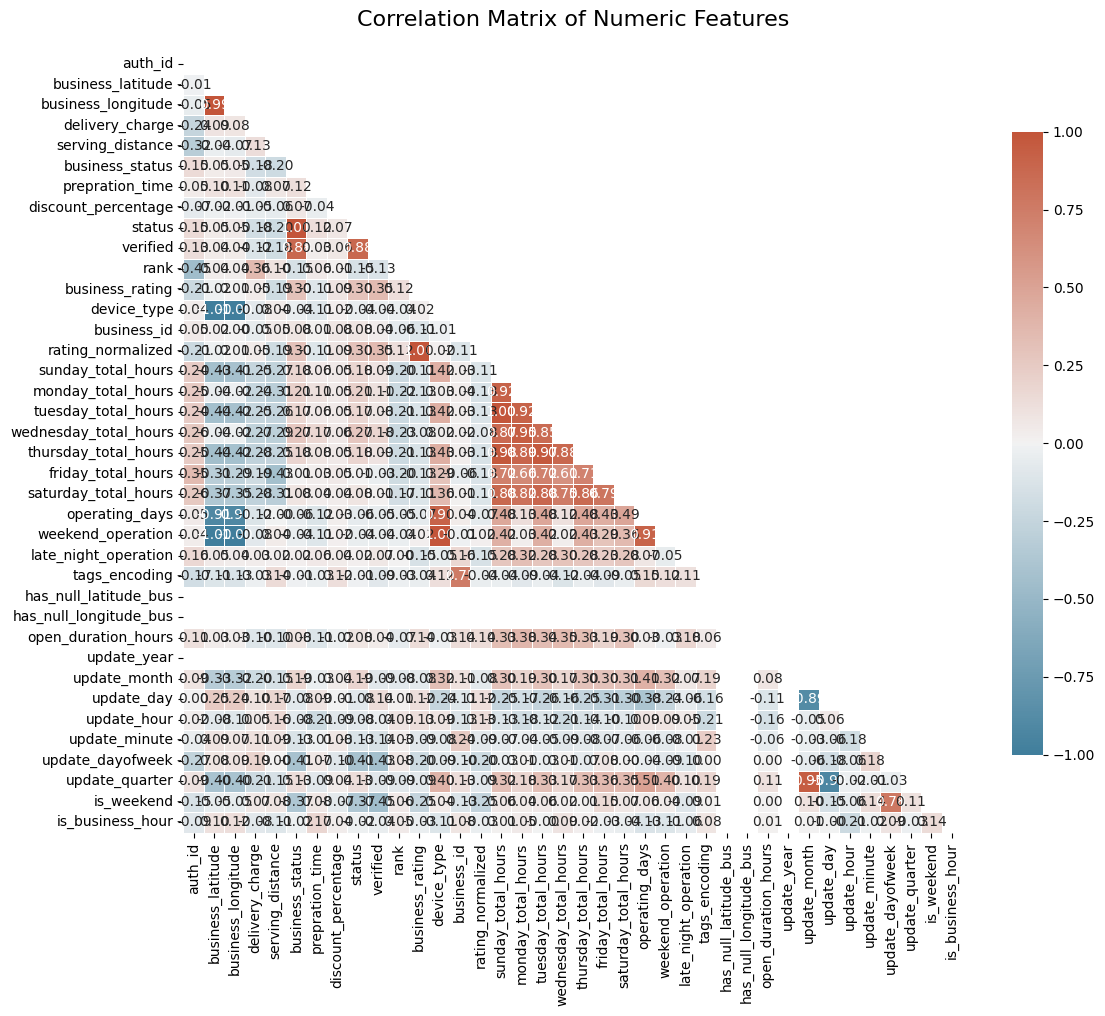

In [75]:
# Replace BusinessDf with your dataframe
corr_matrix = create_correlation_heatmap(BusinessDf, save_path="business_corr_heatmap.png")

# Find highly correlated features
print_high_correlations(corr_matrix, threshold=0.7)

In [76]:
df = pd.merge(UserDf, LocationDf, on='user_id', how='left')
df = pd.merge(df, BusinessDf, how='cross')

In [77]:
TransactionDf = pd.read_csv('Epicurean Eater Choice Challenge/transactions_data.csv')

/tmp/ipykernel_2859209/3561442304.py:1: DtypeWarning: Columns (14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  TransactionDf = pd.read_csv('Epicurean Eater Choice Challenge/transactions_data.csv')


In [78]:
transaction_keys = set(
    tuple(x) for x in TransactionDf[['user_id','user_location_id','business_id']].dropna().values
)

# Step 3: Create the target column by checking if the tuple exists in the set
df['target'] = df.apply(
    lambda row:  1 if (row['user_id'], row['user_location_id'], row['business_id']) in transaction_keys else 0,
    axis=1
)

In [79]:

# Step 1: Convert date columns to datetime
date_cols = ['account_creation_date', 'account_last_update']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Step 2: Extract features from date columns
for col in date_cols:
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_day'] = df[col].dt.day


# Step 4: One-hot encode categorical columns
categorical_cols = ['user_gender', 'user_location_type']
df = pd.get_dummies(df, columns=categorical_cols, dummy_na=True)

# Step 5: Convert only the one-hot encoded columns to int
# First, select only the bool columns (get_dummies returns bool dtype by default)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Optional: fill any NaNs in the numeric columns if needed
df.fillna(0, inplace=True)  # or use a more sophisticated imputation


In [80]:
tags_dummies = pd.get_dummies(df['tags_encoding'], prefix='tag')

# Convert any boolean values to 0/1 integers
tags_dummies = tags_dummies.astype(int)

# Preview the resulting encoded columns
print(f"Shape of encoded tags: {tags_dummies.shape}")
print(tags_dummies.head())

# Now join these new columns with your original dataframe
# Option 1: Replace the original column
df = df.drop('tags_encoding', axis=1)
df = pd.concat([df, tags_dummies], axis=1)

Shape of encoded tags: (3781000, 77)
   tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  tag_9  ...  \
0      1      0      0      0      0      0      0      0      0      0  ...   
1      0      1      0      0      0      0      0      0      0      0  ...   
2      0      0      1      0      0      0      0      0      0      0  ...   
3      0      0      0      1      0      0      0      0      0      0  ...   
4      0      0      0      0      1      0      0      0      0      0  ...   

   tag_67  tag_68  tag_69  tag_70  tag_71  tag_72  tag_73  tag_74  tag_75  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   tag_76  
0      

In [81]:
df['has_discount'] = (df['discount_percentage'] > 0).astype(int)

In [82]:
from sklearn.preprocessing import MinMaxScaler
df['business_rating'] = MinMaxScaler().fit_transform(df[['business_rating']])

df['account_creation_date'] = pd.to_datetime(df['account_creation_date'], errors='coerce')
current_date = pd.Timestamp.now()
df['account_age_days'] = (current_date - df['account_creation_date']).dt.days
df['business_creation_date'] = pd.to_datetime(df['business_creation_date'].astype(str), errors='coerce')
df['updated_at'] = pd.to_datetime(df['updated_at'].astype(str), errors='coerce')
df['business_age_days'] = (df['updated_at'] - df['business_creation_date']).dt.days


df['user_age'] = 2024 - df['user_birth_year']
df['creation_year'] = pd.to_datetime(df['account_creation_date']).dt.year
df['creation_month'] = pd.to_datetime(df['account_creation_date']).dt.month
df['days_since_update'] = (current_date - df['updated_at']).dt.days
df['business_creation_date_hour'] = pd.to_datetime(df['business_creation_date']).dt.hour
df['updated_at_hour'] = pd.to_datetime(df['updated_at']).dt.hour
df['updated_at_month'] = pd.to_datetime(df['updated_at']).dt.month
df['account_last_update_hour'] = pd.to_datetime(df['account_last_update']).dt.hour
df['last_update_year'] = pd.to_datetime(df['account_last_update']).dt.year


In [83]:

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # in kilometers

df['distance_km'] = haversine_distance(df['user_latitude'], df['user_longitude'], df['business_latitude'], df['business_longitude'])
threshold_km = 10
df['is_nearby'] = (df['distance_km'] <= threshold_km).astype(int)

In [84]:
df['within_delivery_range'] = (df['distance_km'] <= df['serving_distance']).astype(int)
df['delivery_buffer'] = df['serving_distance'] - df['distance_km']

In [85]:
current_date = datetime.now()
df['business_month_age'] = (
    (current_date - df['business_creation_date'])
    / pd.Timedelta(days=30.44)  # Average month length
).round().astype(int)
df['business_month_age'] = df['business_month_age'].fillna(-1)

In [86]:
df = pd.get_dummies(df, columns=['business_category'], dummy_na=True)

# Step 5: Convert only the one-hot encoded columns to int
# First, select only the bool columns (get_dummies returns bool dtype by default)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Optional: fill any NaNs in the numeric columns if needed
df.fillna(0, inplace=True)  # or use a more sophisticated imputation

In [87]:
df = pd.get_dummies(df, columns=['rating_category'], dummy_na=True)

# Step 5: Convert only the one-hot encoded columns to int
# First, select only the bool columns (get_dummies returns bool dtype by default)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Optional: fill any NaNs in the numeric columns if needed
df.fillna(0, inplace=True)  # or use a more sophisticated imputation

In [88]:
df.drop(columns=['normalized_tags'],inplace=True)

In [89]:
cat_cols = list(df.select_dtypes("object").columns)
df.drop(columns=cat_cols,inplace=True)

In [90]:

# Assuming 'df' is your DataFrame
def remove_single_value_features(df):
    """
    Removes features that have only one unique value as they don't provide any 
    discriminative information for modeling.
    """
    # Calculate the number of unique values for each column
    unique_counts = df.nunique()
    
    # Find columns with only one unique value
    constant_features = unique_counts[unique_counts == 1].index.tolist()
    
    # Print the features being removed
    if constant_features:
        print(f"Removing {len(constant_features)} constant features:")
        for feature in constant_features:
            print(f"  - '{feature}' with value: {df[feature].iloc[0]}")
    else:
        print("No constant features found.")
    
    # Remove the constant features
    df_cleaned = df.drop(columns=constant_features)
    
    print(f"\nOriginal shape: {df.shape}")
    print(f"New shape: {df_cleaned.shape}")
    
    return df_cleaned

# Apply the function to your DataFrame
df = remove_single_value_features(df)


Removing 7 constant features:
  - 'has_null_latitude_bus' with value: 0
  - 'has_null_longitude_bus' with value: 0
  - 'update_year' with value: 2020
  - 'user_gender_nan' with value: 0
  - 'user_location_type_nan' with value: 0
  - 'business_category_nan' with value: 0
  - 'rating_category_nan' with value: 0

Original shape: (3781000, 166)
New shape: (3781000, 159)


In [91]:

from sklearn.feature_selection import mutual_info_regression
def remove_highly_correlated_features(df, target_col=None, threshold=0.8, method='variance', plot=True):
    """
    Identify and remove highly correlated features, keeping the more beneficial one.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataset to analyze
    target_col : str, optional
        Target variable name (if available)
    threshold : float
        Correlation threshold above which to consider features as highly correlated
    method : str
        Method to decide which feature to keep:
        - 'variance': Keep feature with higher variance (more information)
        - 'missing': Keep feature with fewer missing values
        - 'target': Keep feature with higher correlation to target (requires target_col)
        - 'mi_target': Keep feature with higher mutual information with target (requires target_col)
    plot : bool
        Whether to plot the correlation heatmap before and after feature removal
    
    Returns:
    --------
    df_filtered : pandas DataFrame
        DataFrame with highly correlated features removed
    dropped_features : list
        List of features that were dropped
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    if target_col is not None and target_col in numeric_df.columns:
        y = numeric_df[target_col]
        numeric_df = numeric_df.drop(columns=[target_col])
    else:
        y = None
        if method in ['target', 'mi_target']:
            print(f"Warning: '{method}' method selected but no valid target column provided. Falling back to 'variance' method.")
            method = 'variance'
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr().abs()
    
    # If plot is True, create before-removal heatmap
    if plot:
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(
            corr_matrix, 
            mask=mask,
            cmap=cmap,
            vmax=1.0, 
            vmin=0.0,
            center=0.5,
            square=True, 
            linewidths=.5, 
            annot=True,
            fmt=".2f",
            cbar_kws={"shrink": .8}
        )
        plt.title('Correlation Matrix Before Feature Removal', fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()
    
    # Create map of feature criteria values based on selected method
    feature_values = {}
    
    if method == 'variance':
        for column in numeric_df.columns:
            feature_values[column] = numeric_df[column].var()
    elif method == 'missing':
        for column in numeric_df.columns:
            feature_values[column] = -numeric_df[column].isna().sum()  # Negative because lower is better
    elif method == 'target':
        for column in numeric_df.columns:
            feature_values[column] = abs(np.corrcoef(numeric_df[column], y)[0, 1])
    elif method == 'mi_target':
        # Calculate mutual information
        mi_values = mutual_info_regression(numeric_df, y)
        for i, column in enumerate(numeric_df.columns):
            feature_values[column] = mi_values[i]
    
    # Upper triangular matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    features_to_drop = []
    
    for i, row in enumerate(upper.index):
        for j, col in enumerate(upper.columns):
            if j <= i:  # Skip lower triangle
                continue
            if upper.iloc[i, j] > threshold:
                # Get the two correlated features
                feature1, feature2 = row, col
                
                # Determine which to keep based on the selected method
                if feature_values[feature1] >= feature_values[feature2]:
                    drop_feature = feature2
                else:
                    drop_feature = feature1
                
                # Add to drop list if not already there
                if drop_feature not in features_to_drop:
                    features_to_drop.append(drop_feature)
                    print(f"Correlated pair: {feature1} and {feature2}, correlation: {upper.loc[feature1, feature2]:.3f}")
                    print(f"  -> Dropping {drop_feature} (value: {feature_values[drop_feature]:.4f}), keeping {feature1 if drop_feature == feature2 else feature2} (value: {feature_values[feature1 if drop_feature == feature2 else feature2]:.4f})")
    
    # Drop correlated features
    df_filtered = df.copy()
    if features_to_drop:
        df_filtered = df.drop(columns=features_to_drop)
        print(f"\nDropped {len(features_to_drop)} highly correlated features: {', '.join(features_to_drop)}")
    else:
        print(f"No highly correlated features found above threshold {threshold}")
    
    # Create after-removal correlation matrix
    if plot and features_to_drop:
        numeric_df_filtered = df_filtered.select_dtypes(include=[np.number])
        if target_col is not None and target_col in numeric_df_filtered.columns:
            numeric_df_filtered = numeric_df_filtered.drop(columns=[target_col])
        
        corr_matrix_filtered = numeric_df_filtered.corr().abs()
        
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix_filtered, dtype=bool))
        sns.heatmap(
            corr_matrix_filtered, 
            mask=mask,
            cmap=cmap,
            vmax=1.0, 
            vmin=0.0,
            center=0.5,
            square=True, 
            linewidths=.5, 
            annot=True,
            fmt=".2f",
            cbar_kws={"shrink": .8}
        )
        plt.title('Correlation Matrix After Feature Removal', fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()
    
    return df_filtered, features_to_drop

# Example usage with different methods:

# 1. Using variance method (default)


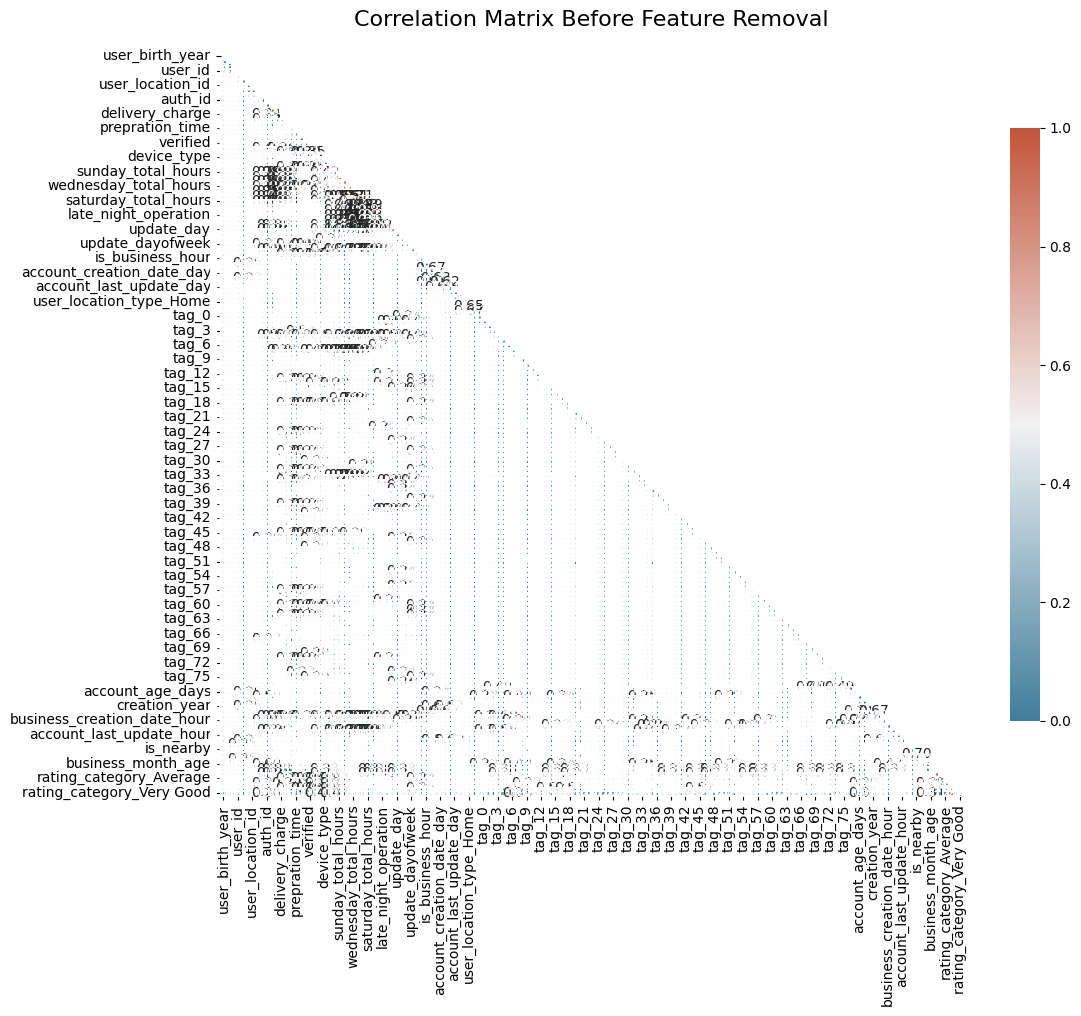

Correlated pair: user_birth_year and user_age, correlation: 1.000
  -> Dropping user_age (value: 0.0019), keeping user_birth_year (value: 0.0019)
Correlated pair: user_longitude and distance_km, correlation: 0.861
  -> Dropping user_longitude (value: 0.0066), keeping distance_km (value: 0.0174)
Correlated pair: has_null_latitude_user and has_null_longitude_user, correlation: 1.000
  -> Dropping has_null_longitude_user (value: 0.0005), keeping has_null_latitude_user (value: 0.0005)
Correlated pair: auth_id and tag_7, correlation: 0.817
  -> Dropping tag_7 (value: 0.0046), keeping auth_id (value: 0.0103)
Correlated pair: business_latitude and business_longitude, correlation: 0.993
  -> Dropping business_longitude (value: 0.0046), keeping business_latitude (value: 0.0046)
Correlated pair: business_latitude and device_type, correlation: 0.997
  -> Dropping device_type (value: 0.0041), keeping business_latitude (value: 0.0046)
Correlated pair: business_latitude and operating_days, correlati

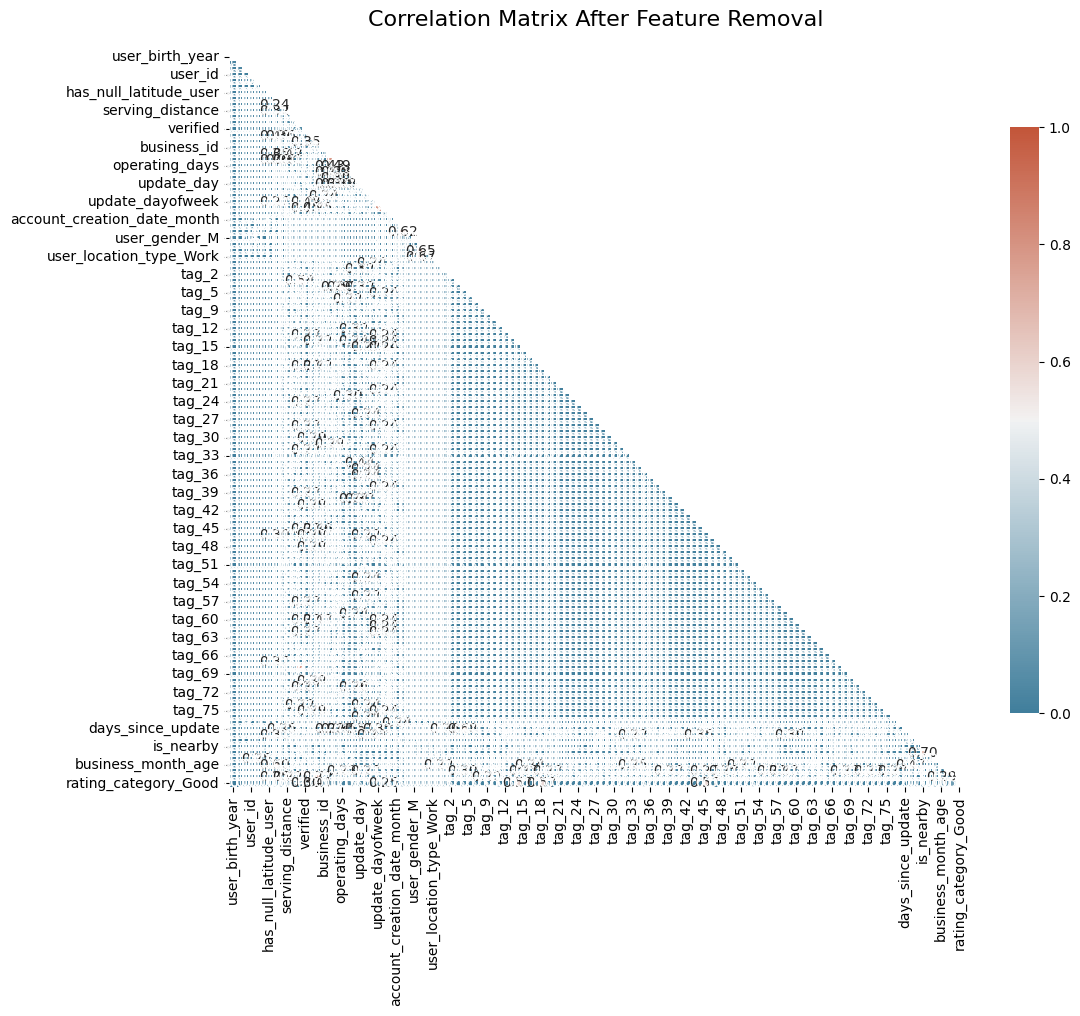

In [92]:
# For feature selection with target variable:
df, dropped_features = remove_highly_correlated_features(
    df,
    target_col='target',  # Your target variable
    threshold=0.8,               # Correlation threshold
    method='target',             # Use correlation with target to decide
    plot=True                    # Show before/after heatmaps
)


In [93]:
df['target'] = df.apply(
    lambda row:  1 if (row['user_id'], row['user_location_id'], row['business_id']) in transaction_keys else 0,
    axis=1
)

In [94]:
def reduce_mem_usage(df, verbose=True, convert_objects=True, object_threshold=0.5):
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f"Initial memory usage: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        # Process numeric columns.
        if pd.api.types.is_numeric_dtype(col_type):
            col_min = df[col].min(skipna=True)
            col_max = df[col].max(skipna=True)

            # If the column is integer type (note: integer columns with NA become float)
            if pd.api.types.is_integer_dtype(col_type):
                if col_min >= np.iinfo(np.int8).min and col_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # Process float columns
                if col_min >= np.finfo(np.float16).min and col_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        # Optionally convert object columns with low cardinality to category
        elif convert_objects and pd.api.types.is_object_dtype(col_type):
            num_unique_values = df[col].nunique(dropna=True)
            num_total_values = len(df[col])
            # Avoid division by zero and convert if ratio is below the threshold
            if num_total_values > 0 and (num_unique_values / num_total_values) < object_threshold:
                df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        reduction = 100 * (start_mem - end_mem) / start_mem
        print(f"Memory usage decreased to: {end_mem:.2f} MB ({reduction:.1f}% reduction)")
    return df

In [95]:
df = reduce_mem_usage(df)

features = list(df.select_dtypes("number").columns)

features.remove('target')
features.remove('user_id')


X = df[features].copy()
y = df['target'].copy()

Initial memory usage: 3504.88 MB
Memory usage decreased to: 612.99 MB (82.5% reduction)


In [96]:
X.head()

/home/mouad.elansari/.conda/envs/jupyter-env/lib/python3.9/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/mouad.elansari/.conda/envs/jupyter-env/lib/python3.9/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,user_birth_year,account_status,account_verified,user_latitude,user_location_id,has_null_latitude_user,auth_id,delivery_charge,serving_distance,prepration_time,...,days_since_update,business_creation_date_hour,account_last_update_hour,is_nearby,within_delivery_range,delivery_buffer,business_month_age,business_category_Restaurants,rating_category_Excellent,rating_category_Good
0,1993,1,1,-0.587891,0,0,119187,0.700195,15,25,...,1868,13,23,0,0,-115.75000,67,1,0,0
1,1993,1,1,-0.587891,0,0,118673,0.700195,15,36,...,1880,14,23,0,0,-85.75000,81,1,1,0
2,1993,1,1,-0.587891,0,0,118663,0.000000,15,36,...,1866,23,23,0,0,-37.62500,81,1,0,0
3,1993,1,1,-0.587891,0,0,118707,0.700195,15,2,...,1865,22,23,0,0,-60.03125,79,1,1,0
4,1993,1,1,-0.587891,0,0,118794,0.700195,10,6,...,1871,13,23,0,0,-126.06250,74,0,0,0


In [97]:
# EMERGENCY: ULTRA-FAST LIGHTGBM TRAINING - FIXED VERSION
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

# Current Date and Time (UTC): 2025-05-17 12:08:07
# Current User: ELANSARI05

# USING EXACTLY YOUR PARAMETERS (just removing early_stopping_round)
original_params = {
  "learning_rate": 0.0760420328725426,
  "max_depth": 10,
  "num_leaves": 150,
  "min_child_samples": 94,
  "subsample": 0.8150249945247859,
  "colsample_bytree": 0.9451361587935696,
  "reg_alpha": 0.006067589949183341,
  "reg_lambda": 0.23881826690686692,
  'n_estimators': 1000,
  'n_jobs': -1,
  'objective': 'binary',
  # 'early_stopping_round': 100,  # This was causing the error - removing only this
  'random_state': 42,
  'class_weight': 'balanced'
}

# THREE-WAY SPLIT
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

# DATASET SIZE ANALYSIS
print(f"Training data: {X_train.shape} - Memory usage: {X_train.memory_usage().sum()/1024**2:.1f} MB")
print(f"Class balance: {np.mean(y_train):.4f} (positive class proportion)")

# TRAIN WITH TIMER
import time
start_time = time.time()
print("Starting training with original parameters...")

# CREATE AND TRAIN MODEL
model = lgb.LGBMClassifier(**original_params)
model.fit(X_train, y_train)

# REPORT TRAINING TIME
training_time = time.time() - start_time
minutes = int(training_time // 60)
seconds = int(training_time % 60)
print(f"Training completed in {minutes} minutes {seconds} seconds")

# QUICK EVALUATION
val_probs = model.predict_proba(X_val)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

# FIND THRESHOLD
precision, recall, thresholds = precision_recall_curve(y_val, val_probs)
thresholds = np.append(thresholds, 1.0)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
threshold = thresholds[optimal_idx]

# APPLY THRESHOLD
test_preds = (test_probs >= threshold).astype(int)

# PRINT RESULTS
print(f"\nOptimal threshold: {threshold:.4f}")
print(f"Test accuracy: {accuracy_score(y_test, test_preds):.4f}")
print(f"Test F1 score: {f1_score(y_test, test_preds):.4f}")
print(f"Test precision: {precision_score(y_test, test_preds):.4f}")
print(f"Test recall: {recall_score(y_test, test_preds):.4f}")

# CONFUSION MATRIX
cm = confusion_matrix(y_test, test_preds)
print(f"\nConfusion Matrix:\n{cm}")

# QUICK FEATURE IMPORTANCE
importance = pd.DataFrame({
    'Feature': X.columns if hasattr(X, 'columns') else [f"F{i}" for i in range(X.shape[1])],
    'Importance': model.feature_importances_
})
print("\nTop 5 Features:")
print(importance.sort_values('Importance', ascending=False).head(5))

Training data: (2268600, 120) - Memory usage: 305.1 MB
Class balance: 0.0134 (positive class proportion)
Starting training with original parameters...
[LightGBM] [Info] Number of positive: 30373, number of negative: 2238227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.857686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1643
[LightGBM] [Info] Number of data points in the train set: 2268600, number of used features: 120
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


KeyboardInterrupt: 

In [ ]:
test_users = pd.read_csv('Epicurean Eater Choice Challenge/test_users_data.csv')
numeric_features = list(test_users.select_dtypes("number").columns)
categorical_features = list(test_users.select_dtypes("object"))

In [ ]:
# Standardize gender values to single uppercase letter (M/F)
test_users['user_gender'] = test_users['user_gender'].str.upper().str[0]

# Replace non-standard gender values with the most common value
test_users.loc[~test_users["user_gender"].isin(['M', 'F']), "user_gender"] = test_users["user_gender"].mode()[0]

# Fill missing values with mode (most frequent value)
test_users["user_language"] = test_users["user_language"].fillna(test_users["user_language"].mode()[0])
test_users.drop(columns=["user_language"])
test_users["user_gender"] = test_users["user_gender"].fillna('other')

test_users["user_birth_year"] = test_users["user_birth_year"].round()

/tmp/ipykernel_2235068/1225961514.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_users["user_language"].fillna(test_users["user_language"].mode()[0], inplace=True)
/tmp/ipykernel_2235068/1225961514.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

In [ ]:
def hundle_anomalies(feature,min_val= None,max_val = None):
    min_anom = []
    max_anom = []
    if min_val != None:
        min_anom = test_users[test_users[feature] < min_val]
    if max_val != None:
        max_anom = test_users[test_users[feature] > max_val]
    print("number of anomalies for the feature ",feature," is:  ",len(max_anom) + len(min_anom))
    if min_val != None:
        median_min = test_users[test_users[feature] >= min_val][feature].median()
        test_users.loc[test_users[feature] < min_val,feature] = median_min
    if max_val != None:
        median_max = test_users[test_users[feature] <= min_val][feature].median()
        test_users.loc[test_users[feature] > max_val,feature] = median_max

hundle_anomalies("user_birth_year",min_val=1925,max_val=2007)

number of anomalies for the feature  user_birth_year  is:   67


In [ ]:
test_users["user_birth_year"] = test_users["user_birth_year"].fillna(test_users["user_birth_year"].median())
test_users['user_birth_year'] = test_users['user_birth_year'].astype(int)

/tmp/ipykernel_2235068/3716967634.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_users["user_birth_year"].fillna(test_users["user_birth_year"].median(),inplace=True)


In [ ]:
test_data = pd.merge(test_users, LocationDf, on='user_id', how='left')
test_data = pd.merge(test_data, BusinessDf, how='cross')

In [ ]:

# Step 1: Convert date columns to datetime
date_cols = ['account_creation_date', 'account_last_update']
for col in date_cols:
    test_data[col] = pd.to_datetime(test_data[col], errors='coerce')

# Step 2: Extract features from date columns
for col in date_cols:
    test_data[f'{col}_year'] = test_data[col].dt.year
    test_data[f'{col}_month'] = test_data[col].dt.month
    test_data[f'{col}_day'] = test_data[col].dt.day


# Step 4: One-hot encode categorical columns
categorical_cols = ['user_gender', 'user_location_type']
test_data = pd.get_dummies(test_data, columns=categorical_cols, dummy_na=True)

# Step 5: Convert only the one-hot encoded columns to int
# First, select only the bool columns (get_dummies returns bool dtype by default)
bool_cols = test_data.select_dtypes(include='bool').columns
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Optional: fill any NaNs in the numeric columns if needed
test_data.fillna(0, inplace=True)  # or use a more sophisticated imputation


In [ ]:
tags_dummies = pd.get_dummies(test_data['tags_encoding'], prefix='tag')

# Convert any boolean values to 0/1 integers
tags_dummies = tags_dummies.astype(int)

# Preview the resulting encoded columns
print(f"Shape of encoded tags: {tags_dummies.shape}")
print(tags_dummies.head())

# Now join these new columns with your original dataframe
# Option 1: Replace the original column
test_data = test_data.drop('tags_encoding', axis=1)
test_data = pd.concat([test_data, tags_dummies], axis=1)

Shape of encoded tags: (2040300, 77)
   tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  tag_9  ...  \
0      1      0      0      0      0      0      0      0      0      0  ...   
1      0      1      0      0      0      0      0      0      0      0  ...   
2      0      0      1      0      0      0      0      0      0      0  ...   
3      0      0      0      1      0      0      0      0      0      0  ...   
4      0      0      0      0      1      0      0      0      0      0  ...   

   tag_67  tag_68  tag_69  tag_70  tag_71  tag_72  tag_73  tag_74  tag_75  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   tag_76  
0      

In [ ]:
test_data['has_discount'] = (test_data['discount_percentage'] > 0).astype(int)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
test_data['business_rating'] = MinMaxScaler().fit_transform(test_data[['business_rating']])

test_data['account_creation_date'] = pd.to_datetime(test_data['account_creation_date'], errors='coerce')
current_date = pd.Timestamp.now()
test_data['account_age_days'] = (current_date - test_data['account_creation_date']).dt.days
test_data['business_creation_date'] = pd.to_datetime(test_data['business_creation_date'].astype(str), errors='coerce')
test_data['updated_at'] = pd.to_datetime(test_data['updated_at'].astype(str), errors='coerce')
test_data['business_age_days'] = (test_data['updated_at'] - test_data['business_creation_date']).dt.days


test_data['user_age'] = 2024 - test_data['user_birth_year']
test_data['creation_year'] = pd.to_datetime(test_data['account_creation_date']).dt.year
test_data['creation_month'] = pd.to_datetime(test_data['account_creation_date']).dt.month
test_data['days_since_update'] = (current_date - test_data['updated_at']).dt.days
test_data['business_creation_date_hour'] = pd.to_datetime(test_data['business_creation_date']).dt.hour
test_data['updated_at_hour'] = pd.to_datetime(test_data['updated_at']).dt.hour
test_data['updated_at_month'] = pd.to_datetime(test_data['updated_at']).dt.month
test_data['account_last_update_hour'] = pd.to_datetime(test_data['account_last_update']).dt.hour
test_data['last_update_year'] = pd.to_datetime(test_data['account_last_update']).dt.year


In [ ]:

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # in kilometers

test_data['distance_km'] = haversine_distance(test_data['user_latitude'], test_data['user_longitude'], test_data['business_latitude'], test_data['business_longitude'])
threshold_km = 10
test_data['is_nearby'] = (test_data['distance_km'] <= threshold_km).astype(int)

In [ ]:
test_data['within_delivery_range'] = (test_data['distance_km'] <= test_data['serving_distance']).astype(int)
test_data['delivery_buffer'] = test_data['serving_distance'] - test_data['distance_km']

In [ ]:
current_date = datetime.now()
test_data['business_month_age'] = (
    (current_date - test_data['business_creation_date'])
    / pd.Timedelta(days=30.44)  # Average month length
).round().astype(int)
test_data['business_month_age'] = test_data['business_month_age'].fillna(-1)

In [ ]:
test_data = pd.get_dummies(test_data, columns=['business_category'], dummy_na=True)

# Step 5: Convert only the one-hot encoded columns to int
# First, select only the bool columns (get_dummies returns bool dtype by default)
bool_cols = test_data.select_dtypes(include='bool').columns
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Optional: fill any NaNs in the numeric columns if needed
test_data.fillna(0, inplace=True)  # or use a more sophisticated imputation

In [ ]:
test_data = pd.get_dummies(test_data, columns=['rating_category'], dummy_na=True)

# Step 5: Convert only the one-hot encoded columns to int
# First, select only the bool columns (get_dummies returns bool dtype by default)
bool_cols = test_data.select_dtypes(include='bool').columns
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Optional: fill any NaNs in the numeric columns if needed
test_data.fillna(0, inplace=True)  # or use a more sophisticated imputation

In [ ]:
test_data.drop(columns=['normalized_tags'],inplace=True)

In [ ]:
cat_cols = list(test_data.select_dtypes("object").columns)
test_data.drop(columns=cat_cols,inplace=True)

In [ ]:
features = X.columns.tolist()


In [ ]:
# Option 2: Using optimal threshold found from validation
test_probs = model.predict_proba(test_data[features])[:, 1]
test_data['probability'] = test_probs
test_data['target'] = (test_probs >= threshold).astype(int)

# Check the predictions
print(f"Predicted positives: {test_data['target'].sum()} ({100*test_data['target'].mean():.2f}%)")

In [ ]:
submission = pd.read_csv('SampleSubmission.csv')


In [ ]:
test_data['ID'] = test_data['user_id'].astype(str) + ' - ' + test_data['user_location_id'].astype(str) + ' - ' + test_data['business_id'].astype(str)
test_data['ID'].drop_duplicates(inplace=True)

In [ ]:
submission =  submission.merge(test_data, on='ID', how='inner')


In [ ]:
submission = pd.DataFrame({
    'ID' : submission['ID'],
    'target':  submission['target_y']
})

In [ ]:
print(submission['ID'].duplicated().sum())
submission.drop_duplicates(subset=['ID'], inplace=True)

3000


In [ ]:
print(submission.shape)

(2037300, 2)


In [ ]:
print(submission[submission['target'] == 1].shape[0]/submission.shape[0])

0.2561664948706622


In [ ]:
submission.to_csv('submission.csv', index=False)